In [8]:
import japanize_matplotlib
import pickle
import statistics

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint
from sklearn.metrics import mean_absolute_error
from tqdm.auto import tqdm

In [9]:
plt.rcParams["font.family"] = "IPAexGothic"

pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

In [10]:
def W_n(n):
    random_state = 0
    W = np.load(f"nmf_w/nmf_w_r{str(random_state)}/nmf_w_{n}.npy")
    return W

In [11]:
df_result = pd.read_csv("human0821.csv")
df_gt = pd.read_csv("all_data.csv", index_col=0)
df_t = df_gt.T
selected_ids = list(set(df_result["target_ID"]))
df_drop = df_gt.drop(selected_ids, axis=0)
df_drop.shape
df_train = pd.read_csv("train.csv", index_col=0)
df_test = pd.read_csv("test.csv", index_col=0)

In [12]:
matrix_dict = {}

for dim in tqdm(range(5, 30)):
    matrix_dict[dim] = [
        np.load(f"nmf_w/drop_selected/nmf_w_r{i}/nmf_50000_w_{dim}_r{i}.npy") for i in range(1000)
    ]

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
np.load("nmf_w/drop_selected/nmf_w_r0/nmf_w_5_r0.npy").shape

(100, 5)

In [14]:

samples = []

for index, row in tqdm(df_result.iterrows()):
    data = {}
    data["name"] = row["name"]
    data["target_id"] = row["target_ID"]
    data["clicked_count"] = row["clicked_count"]
    data["clicked_images"] = sorted([int(x) for x in row["clicked_images"].split(",")])
    q_gt = df_gt.iloc[data["target_id"]].to_numpy()
    x = df_gt.iloc[data["target_id"], data["clicked_images"]].to_numpy()


    target_row = df_gt[df_gt.index==data["target_id"]]
    correct_answers = []

    MAE = {}
    qs = {}
    Answers = {}
    q_Answers = {}
    MAE_10_pred = {}

    for n in range(5, 30):
        q_array = []
        for random_state in range(1000):
            W = matrix_dict[n][random_state]
            W1 = W[data["clicked_images"]]
            W1_inv = np.linalg.pinv(W1)
            h_est = np.dot(W1_inv, x)
            q = np.dot(W, h_est)
            q_array.append(q)
        q = sum(q_array) / len(q_array)
        q[q < 0] = 0
        q[q > 10] = 10
        MAE[n] = mean_absolute_error(q_gt, q)
        qs[n] = q

        answers = []
        q_answers = []
        target_row = df_gt[df_gt.index==data["target_id"]]
        correct_answers = []
        for i in range(10):
            image_id = row[f"ID_of_image{i}"]
            answer = row[f"score_of_image{i}"]
            answers.append(answer)
            q_answers.append(q[image_id])
            correct = target_row[f"No.{image_id+1}の画像があなたの好みであるかを0から10で評価してください．"]
            correct_answers.append(correct)
        Answers[n] = answers
        q_Answers[n] = q_answers
        MAE_10_pred[n] = mean_absolute_error(q_answers, correct_answers)

    data["MAE"] = MAE
    data["q"] = qs
    data["answers"] = Answers
    data["q_answers"] = q_Answers
    data["MAE_10_human"] = mean_absolute_error(answers, correct_answers)
    data["MAE_10_pred"] = MAE_10_pred
    samples.append(data)

0it [00:00, ?it/s]

In [15]:
clicked_counts = []
MAE5, MAE15, MAE25 = [], [], []
for data in samples:
    clicked_counts.append(data["clicked_count"])
    MAE5.append(data["MAE"][5])
    MAE15.append(data["MAE"][15])
    MAE25.append(data["MAE"][25])

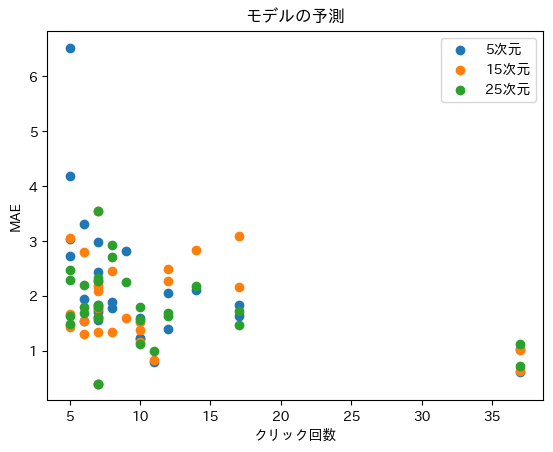

In [16]:
plt.scatter(clicked_counts, MAE5, label="5次元")
plt.scatter(clicked_counts, MAE15, label="15次元")
plt.scatter(clicked_counts, MAE25, label="25次元")
plt.title("モデルの予測")
plt.xlabel("クリック回数")
plt.ylabel("MAE")
plt.legend()

In [17]:
MAE_10_human, MAE_10_pred_5, MAE_10_pred_15, MAE_10_pred_25 = [], [], [], []

for i, sample in enumerate(samples):
    MAE_10_human.append(sample["MAE_10_human"])
    MAE_10_pred_5.append(sample["MAE_10_pred"][5])
    MAE_10_pred_15.append(sample["MAE_10_pred"][15])
    MAE_10_pred_25.append(sample["MAE_10_pred"][25])

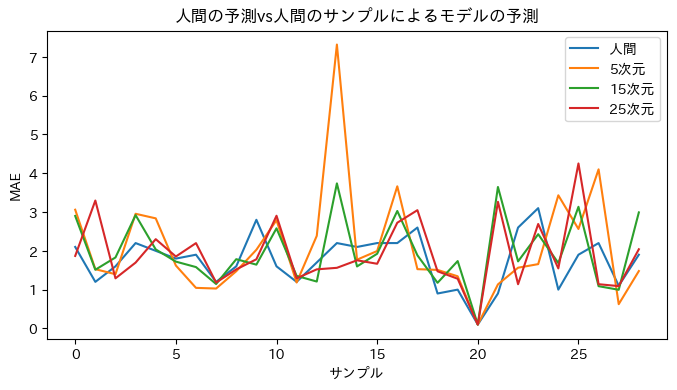

In [18]:
x = list(range(len(samples)))

# グラフを描画するためのAxesオブジェクトを作成
plt.figure(figsize=(8, 4))  # グラフのサイズを指定
ax = plt.gca()

sns.lineplot(x=x, y=MAE_10_human, ax=ax, label='人間')
sns.lineplot(x=x, y=MAE_10_pred_5, ax=ax, label='5次元')
sns.lineplot(x=x, y=MAE_10_pred_15, ax=ax, label='15次元')
sns.lineplot(x=x, y=MAE_10_pred_25, ax=ax, label='25次元')

# グラフにタイトルと軸ラベルを追加
plt.title('人間の予測vs人間のサンプルによるモデルの予測')
plt.xlabel('サンプル')
plt.ylabel('MAE')

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()

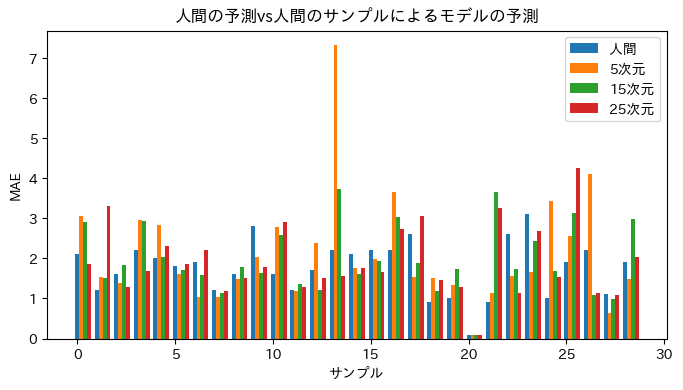

In [19]:
x = np.array(range(len(samples)))

# グラフを描画するためのAxesオブジェクトを作成
plt.figure(figsize=(8, 4))  # グラフのサイズを指定
ax = plt.gca()

plt.bar(x=x, height=MAE_10_human, width=0.2, label='人間')
plt.bar(x=x+0.2, height=MAE_10_pred_5, width=0.2, label='5次元')
plt.bar(x=x+0.4, height=MAE_10_pred_15, width=0.2, label='15次元')
plt.bar(x=x+0.6, height=MAE_10_pred_25, width=0.2, label='25次元')

# グラフにタイトルと軸ラベルを追加
plt.title('人間の予測vs人間のサンプルによるモデルの予測')
plt.xlabel('サンプル')
plt.ylabel('MAE')

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()


In [20]:
MAE_pred_all = [[] for _ in range(5, 30)]

for sample in samples:
    for i in range(5, 30):
        MAE_pred_all[i-5].append(sample["MAE_10_pred"][i])

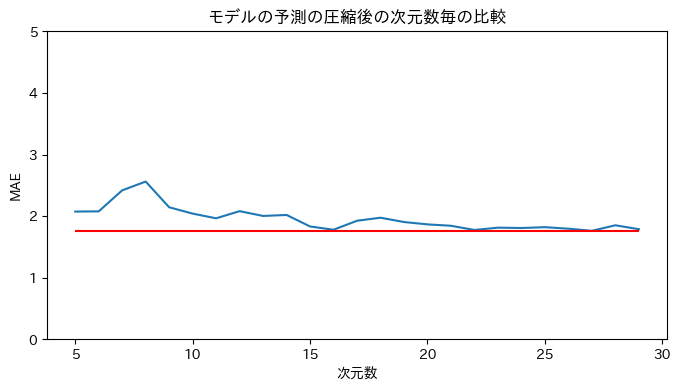

In [21]:
MAE_all = [[] for _ in range(5, 30)]

for sample in samples:
    for i in range(5, 30):
        MAE_all[i-5].append(sample["MAE"][i])

x = list(range(5, 30))
MAE_mean_all = [statistics.mean(mae) for mae in MAE_all]

# グラフを描画するためのAxesオブジェクトを作成
plt.figure(figsize=(8, 4))  # グラフのサイズを指定

sns.lineplot(x=x, y=MAE_mean_all)

plt.hlines(statistics.mean(MAE_10_human), 5, 29, color="red")
plt.ylim(0, 5)

# グラフにタイトルと軸ラベルを追加
plt.title('モデルの予測の圧縮後の次元数毎の比較')
plt.xlabel('次元数')
plt.ylabel('MAE')


# グラフを表示
plt.show()

In [22]:
dim_MAE = []

for sample in samples:
    for i in range(5, 30):
        dim_MAE.append([i, sample["MAE_10_pred"][i]])

df_dim_MAE = pd.DataFrame(dim_MAE, columns=["dim", "MAE"])


<Figure size 800x400 with 0 Axes>

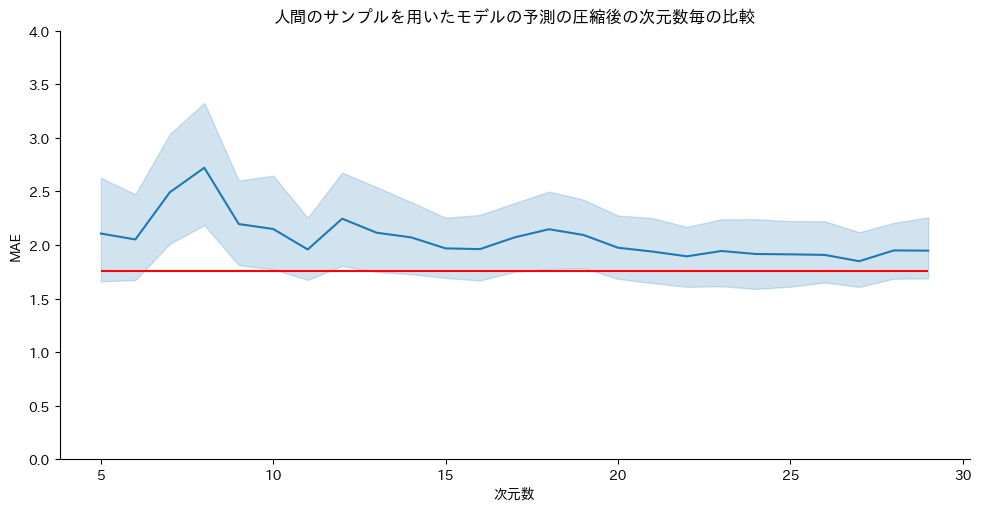

In [83]:
x = list(range(5, 30))
MAE_pred_mean_all = [statistics.mean(mae) for mae in MAE_pred_all]

# グラフを描画するためのAxesオブジェクトを作成
plt.figure(figsize=(8, 4))  # グラフのサイズを指定
sns.relplot(data=df_dim_MAE, x="dim", y="MAE", kind='line', aspect=2)
plt.hlines(statistics.mean(MAE_10_human), 5, 29, color="red")
plt.ylim(1, 4)
# グラフにタイトルと軸ラベルを追加
plt.title('人間のサンプルを用いたモデルの予測の圧縮後の次元数毎の比較')
plt.xlabel('次元数')
plt.ylabel('MAE')


# グラフを表示
plt.show()

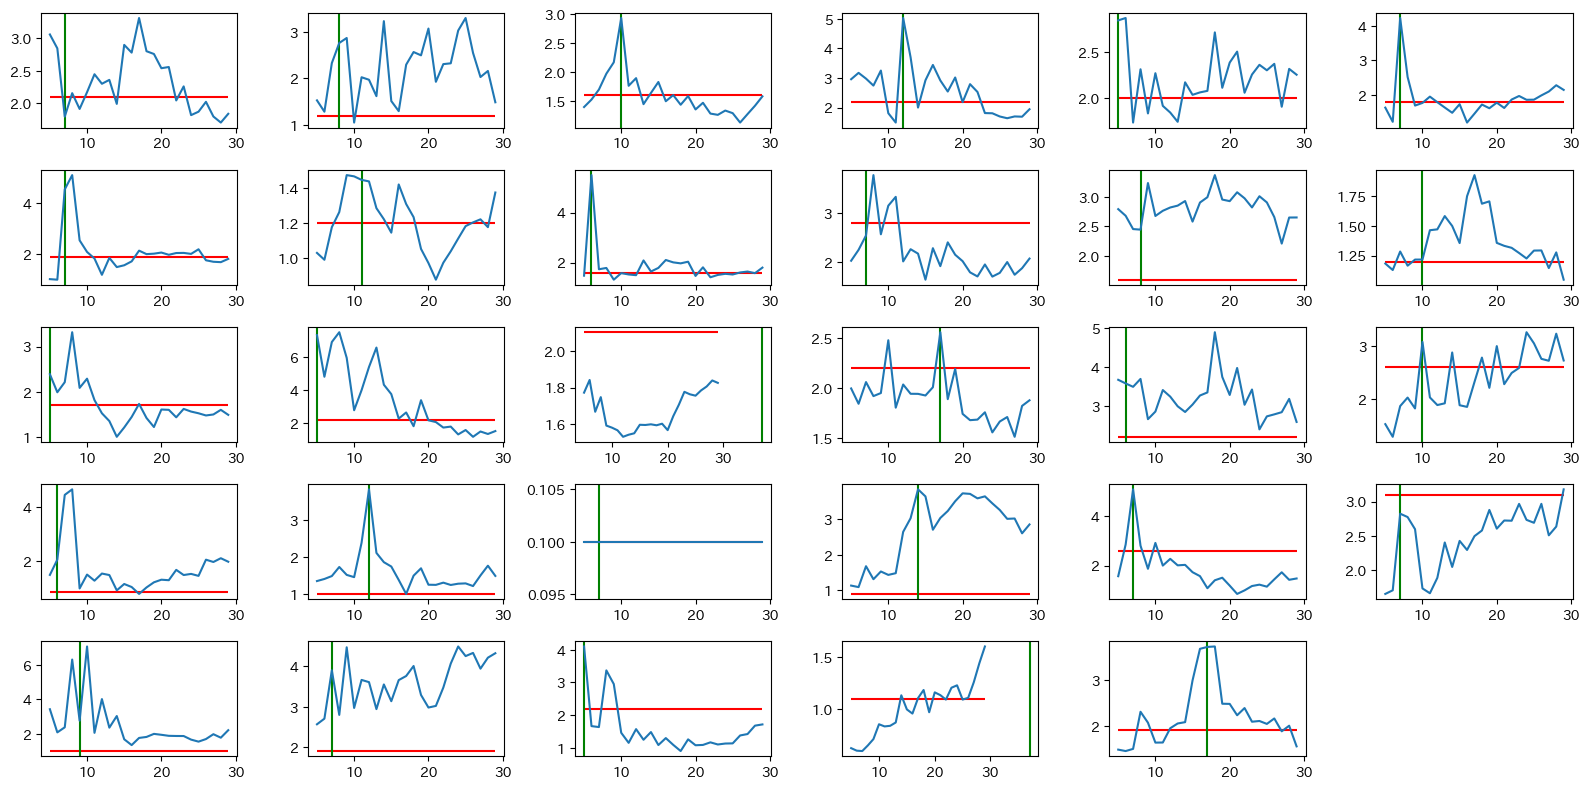

In [79]:
x = list(range(5, 30))

plt.rcParams["figure.figsize"] = (16, 8)
for index, sample in enumerate(samples):
    plt.subplot(5, 6, index+1)
    plt.hlines(sample["MAE_10_human"], 5, 29, color="red")
    plt.axvline(sample["clicked_count"], color="green")
    sns.lineplot(x=x, y=list(sample["MAE_10_pred"].values()))

plt.tight_layout()

In [25]:
matrix_dict_train = {}

for dim in tqdm(range(5, 30)):
    matrix_dict_train[dim] = [
        np.load(f"nmf_w/train/nmf_w_r{i}/nmf_50000_w_{dim}_r{i}.npy") for i in range(1000)
    ]

  0%|          | 0/25 [00:00<?, ?it/s]

In [28]:

score = []

for index, row in tqdm(df_result.iterrows()):
    name = row["name"]
    clicked_count = row["clicked_count"]
    clicked_images = sorted([int(x) for x in row["clicked_images"].split(",")])

    MAE_10_pred = {}

    target_images_id = [row[f"ID_of_image{i}"] for i in range(10)]
    target_cols = [f"No.{id+1}の画像があなたの好みであるかを0から10で評価してください．"  for id in target_images_id]
    correct_answers = df_test.loc[:, target_cols].to_numpy().T
    for n in range(5, 30):
        Q_array = []
        for random_state in range(1000):
            W = matrix_dict_train[n][random_state]
            W1 = W[clicked_images]
            W1_inv = np.linalg.pinv(W1)
            X = df_test.iloc[:, clicked_images].to_numpy().T
            H_est = np.dot(W1_inv, X)
            Q = np.dot(W, H_est)
            Q_array.append(Q)
        Q_mean = sum(Q_array) / len(Q_array)
        Q_mean[Q_mean < 0] = 0
        Q_mean[Q_mean > 10] = 10
        MAE_10_pred[n] = np.mean(np.abs(correct_answers - Q_mean[target_images_id]), axis=0)

    score.append(MAE_10_pred)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

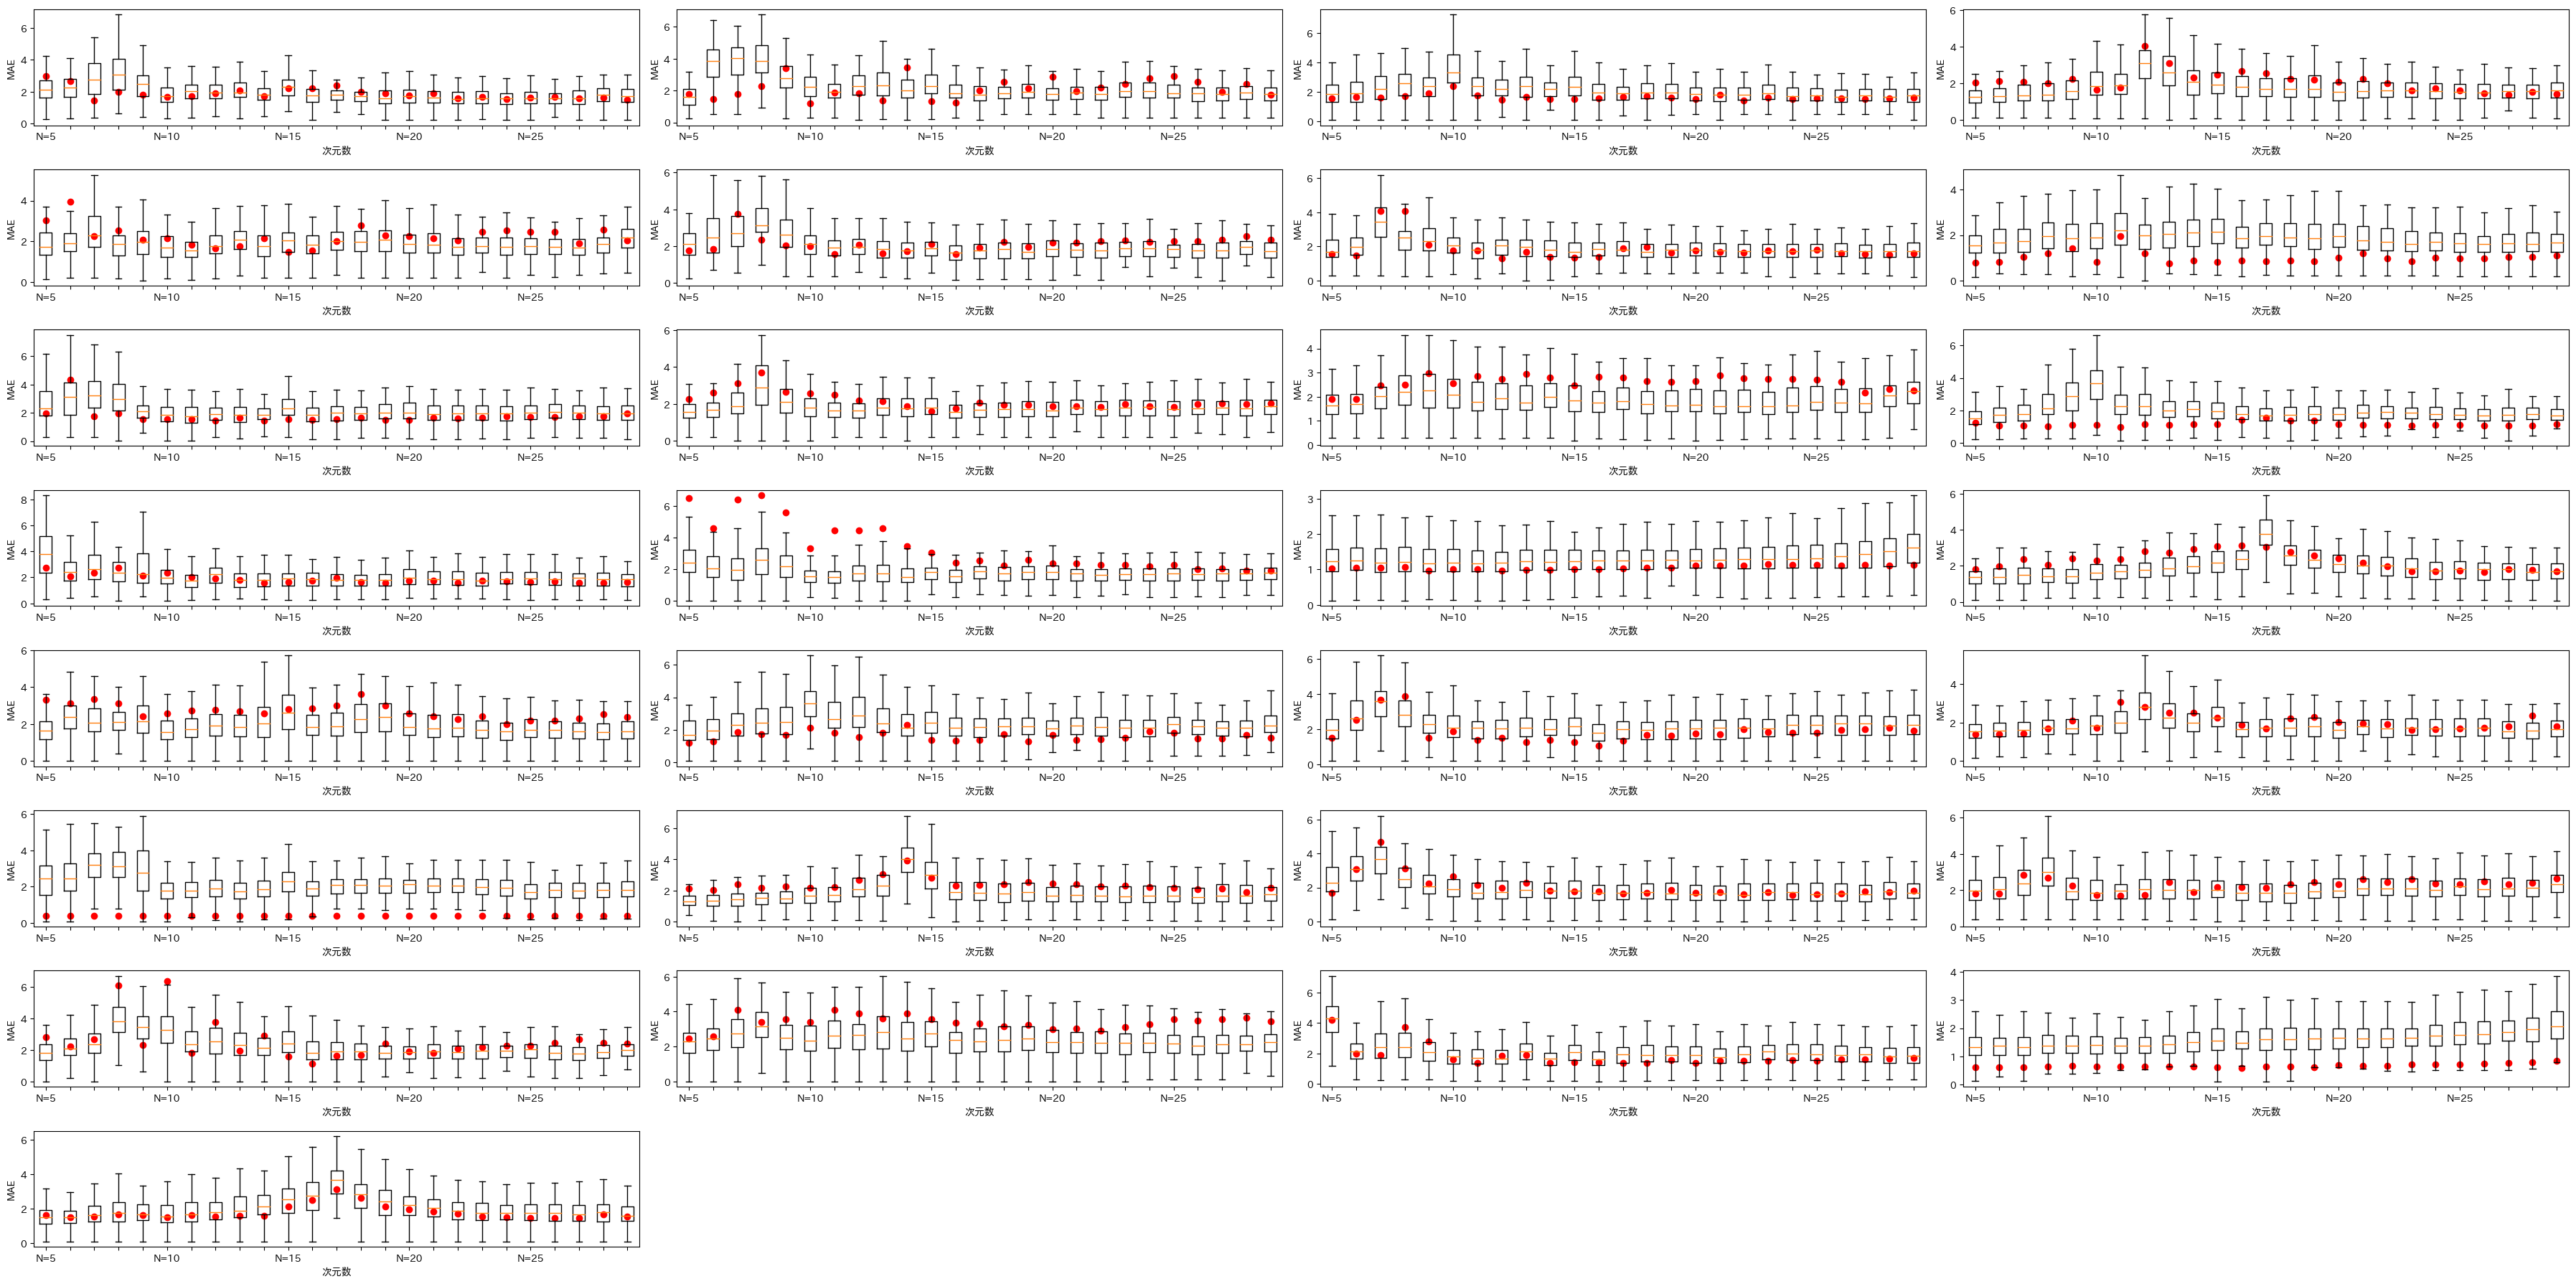

In [32]:
plt.rcParams["figure.figsize"] = (36, 18)
for index, result in tqdm(enumerate(score)):
    plt.subplot(8, 4, index+1)
    plt.boxplot(result.values(), labels=[f"N={i}" if i % 5 == 0 else "" for i in range(5, 30)], sym="", vert=True)
    plt.scatter(range(1, 26), [samples[index]["MAE"][i] for i in range(5, 30)], marker='o', color='red', label='特定の値')
    plt.xlabel("次元数")
    plt.ylabel("MAE")
    plt.savefig("other_person_prediction.png")

plt.tight_layout()

In [33]:

score_3dim = []

for index, row in tqdm(df_result.iterrows()):
    name = row["name"]
    clicked_count = row["clicked_count"]
    clicked_images = sorted([int(x) for x in row["clicked_images"].split(",")])

    MAE_10_pred = {}

    target_images_id = [row[f"ID_of_image{i}"] for i in range(10)]
    target_cols = [f"No.{id+1}の画像があなたの好みであるかを0から10で評価してください．"  for id in target_images_id]
    correct_answers = df_test.loc[:, target_cols].to_numpy().T
    for n in (5, 10, 15):
        Q_array = []
        for random_state in range(1000):
            W = matrix_dict_train[n][random_state]
            W1 = W[clicked_images]
            W1_inv = np.linalg.pinv(W1)
            X = df_test.iloc[:, clicked_images].to_numpy().T
            H_est = np.dot(W1_inv, X)
            Q = np.dot(W, H_est)
            Q_array.append(Q)
        Q_mean = sum(Q_array) / len(Q_array)
        Q_mean[Q_mean < 0] = 0
        Q_mean[Q_mean > 10] = 10
        MAE_10_pred[n] = np.mean(np.abs(correct_answers - Q_mean[target_images_id]), axis=0)

    score_3dim.append(MAE_10_pred)

0it [00:00, ?it/s]

In [39]:
score_3dim[0][5]

array([2.80638217, 3.46466252, 1.76484878, 2.64884536, 2.50576873,
       1.50882326, 1.24721322, 2.10924045, 3.29925021, 0.90886682,
       3.35756792, 2.76466656, 2.60315143, 1.06383021, 1.56256632,
       1.85030964, 2.56061241, 2.80498024, 2.01431665, 2.72716113,
       5.26237348, 1.93682646, 1.96001357, 2.41504446, 1.73897544,
       1.23099523, 1.07743904, 1.31267552, 1.27753046, 1.50030439,
       1.9034011 , 2.59805961, 1.91219738, 1.68071283, 2.83903294,
       4.49986783, 2.61656   , 1.66550633, 3.14799958, 2.15689961,
       1.81746038, 1.90800663, 2.18115907, 1.92643292, 1.67967338,
       2.17093362, 2.43563114, 1.36549076, 2.21798718, 0.86749342,
       2.86551401, 2.70211493, 2.95561779, 2.48130858, 3.04827587,
       2.19368841, 2.2069498 , 1.54743168, 2.91879871, 3.23513018,
       2.29761014, 4.15605309, 3.91436451, 3.08947396, 2.57156623,
       1.6448757 , 2.46709276, 3.34538769, 1.70256447, 4.22824816,
       2.20756137, 4.95652639, 2.17126621, 2.25615269, 0.99926

0it [00:00, ?it/s]

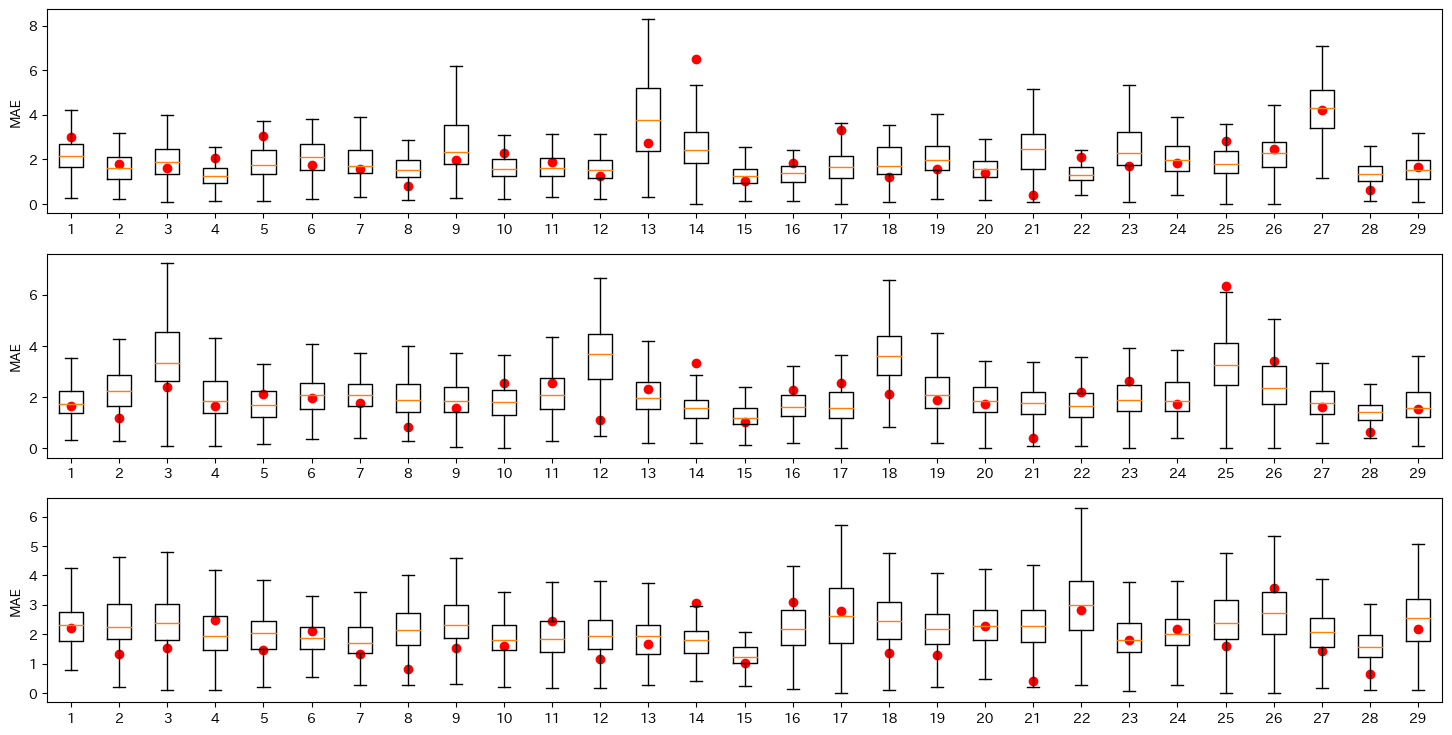

In [44]:
plt.rcParams["figure.figsize"] = (18, 9)
for index, dim in tqdm(enumerate(list((5, 10, 15)))):
    plt.subplot(3, 1, index+1)
    plt.boxplot([result[dim] for result in score_3dim], sym="", vert=True)
    plt.scatter(range(1, len(score_3dim)+1), [sample["MAE"][dim] for sample in samples], marker='o', color='red', label='特定の値')
    plt.ylabel("MAE")
    plt.savefig("other_person_prediction.png")

0it [00:00, ?it/s]

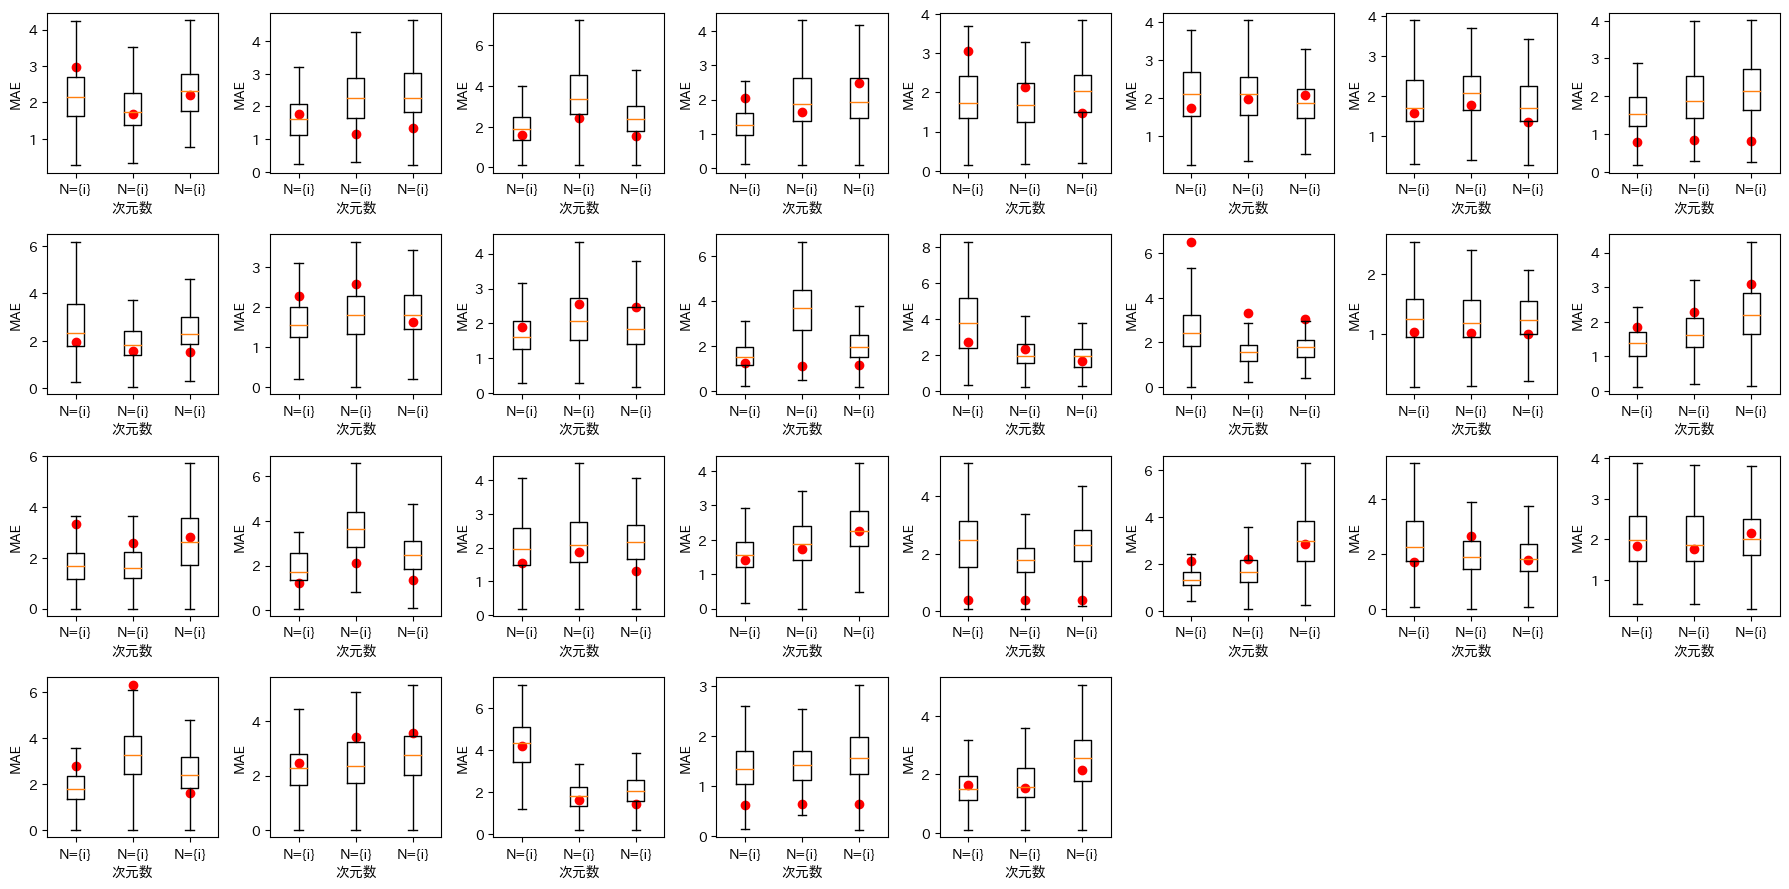

In [36]:
plt.rcParams["figure.figsize"] = (18, 9)
for index, result in tqdm(enumerate(score_3dim)):
    plt.subplot(4, 8, index+1)
    plt.boxplot(result.values(), labels=["N={i}" for i in (5, 10, 15)], sym="", vert=True)
    plt.scatter(range(1, 4), [samples[index]["MAE"][i] for i in (5, 10, 15)], marker='o', color='red', label='特定の値')
    plt.xlabel("次元数")
    plt.ylabel("MAE")
    plt.savefig("other_person_prediction.png")

plt.tight_layout()

In [46]:
dims = (5, 10, 15)

In [47]:
progress_result = []

In [48]:
for index, row in tqdm(df_result.iterrows()):
    name = row["name"]
    target_id= row["target_ID"]
    clicked_count = row["clicked_count"]
    clicked_images = [int(x) for x in row["clicked_images"].split(",")]
    q_gt = df_gt.iloc[target_id].to_numpy()

    target_images_id = [row[f"ID_of_image{i}"] for i in range(10)]
    target_cols = [f"No.{id+1}の画像があなたの好みであるかを0から10で評価してください．"  for id in target_images_id]
    correct_answers = df_gt.loc[target_id, target_cols].to_numpy().T

    MAE = {}
    MAE_selected = {}
    for n in tqdm(dims):
        image_set = set(range(100))
        MAE[n] = {}
        MAE_selected[n] = {}
        for end in range(len(clicked_images)):
            MAE[n][end] = {}
            for id in image_set:
                images_add = clicked_images[:end]
                images_add.append(id)
                images_add.sort()
                x1 = df_gt.iloc[target_id, images_add].to_numpy()

                q_array = []
                for random_state in range(1000):
                    W = matrix_dict[n][random_state]
                    W1 = W[images_add]
                    W1_inv = np.linalg.pinv(W1)
                    h_est = np.dot(W1_inv, x1)
                    q = np.dot(W, h_est)
                    q_array.append(q)
                q_mean = sum(q_array) / len(q_array)
                q_mean[q_mean < 0] = 0
                q_mean[q_mean > 10] = 10

                mae = np.mean(np.abs(correct_answers - q_mean[target_images_id]))
                MAE[n][end][id] = mae
                if id == clicked_images[end]:
                    MAE_selected[n][end] = mae
            image_set.remove(clicked_images[end])

    result = {}
    result["MAE"] = MAE
    result["MAE_selected"] = MAE_selected
    result["clicked_images"] = clicked_images
    with open(f"progress_result/progress_result_0_10_{index}.pkl", "wb") as file:
        pickle.dump(data, file)
    progress_result.append(result)

0it [00:00, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [49]:
MAE = []

for index, row in df_result.iterrows():
    target_id = row["target_ID"]
    target_row = df_gt[df_gt.index==target_id]
    answers = []
    correct_answers = []
    for i in range(10):
        image_id = row[f"ID_of_image{i}"]
        answer = row[f"score_of_image{i}"]
        answers.append(answer)
        correct = target_row[f"No.{image_id+1}の画像があなたの好みであるかを0から10で評価してください．"]
        correct_answers.append(correct)
    mae = mean_absolute_error(correct_answers, answers)
    MAE.append(mae)

df_result["MAE"] = MAE

0it [00:00, ?it/s]

7 2 ['0', '', '2', '', '4', '', '6']
8 2 ['0', '', '2', '', '4', '', '6', '']
10 3 ['0', '', '', '3', '', '', '6', '', '', '9']
12 4 ['0', '', '', '', '4', '', '', '', '8', '', '', '']
5 1 ['0', '1', '2', '3', '4']
7 2 ['0', '', '2', '', '4', '', '6']
7 2 ['0', '', '2', '', '4', '', '6']
11 3 ['0', '', '', '3', '', '', '6', '', '', '9', '']


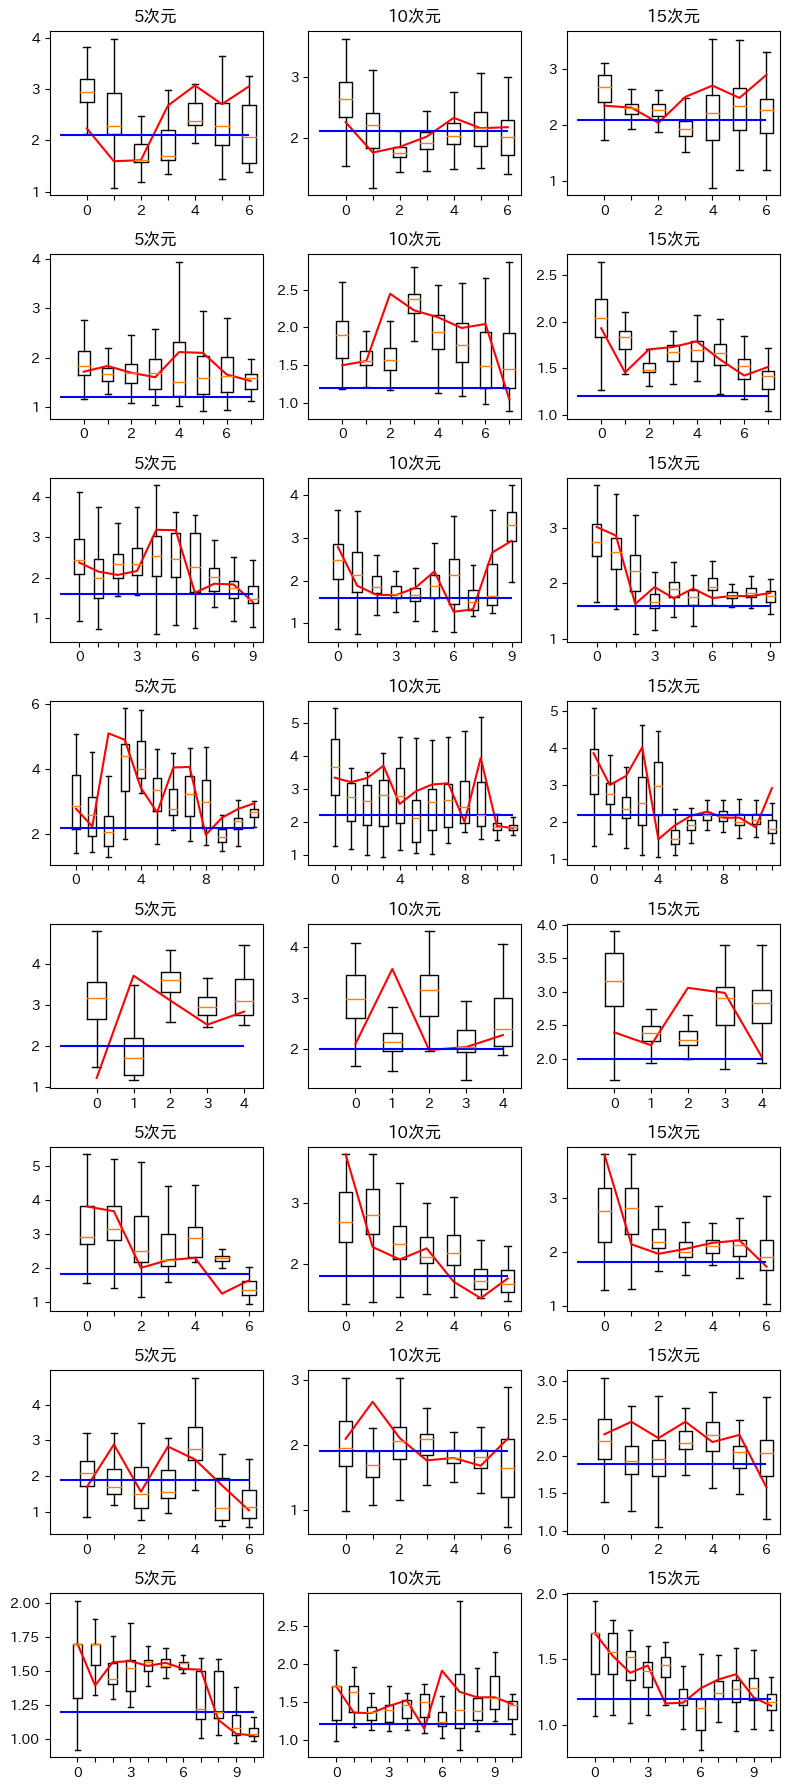

6 2 ['0', '', '2', '', '4', '']
7 2 ['0', '', '2', '', '4', '', '6']
8 2 ['0', '', '2', '', '4', '', '6', '']
10 3 ['0', '', '', '3', '', '', '6', '', '', '9']
5 1 ['0', '1', '2', '3', '4']
5 1 ['0', '1', '2', '3', '4']
37 12 ['0', '', '', '', '', '', '', '', '', '', '', '', '12', '', '', '', '', '', '', '', '', '', '', '', '24', '', '', '', '', '', '', '', '', '', '', '', '36']
17 5 ['0', '', '', '', '', '5', '', '', '', '', '10', '', '', '', '', '15', '']


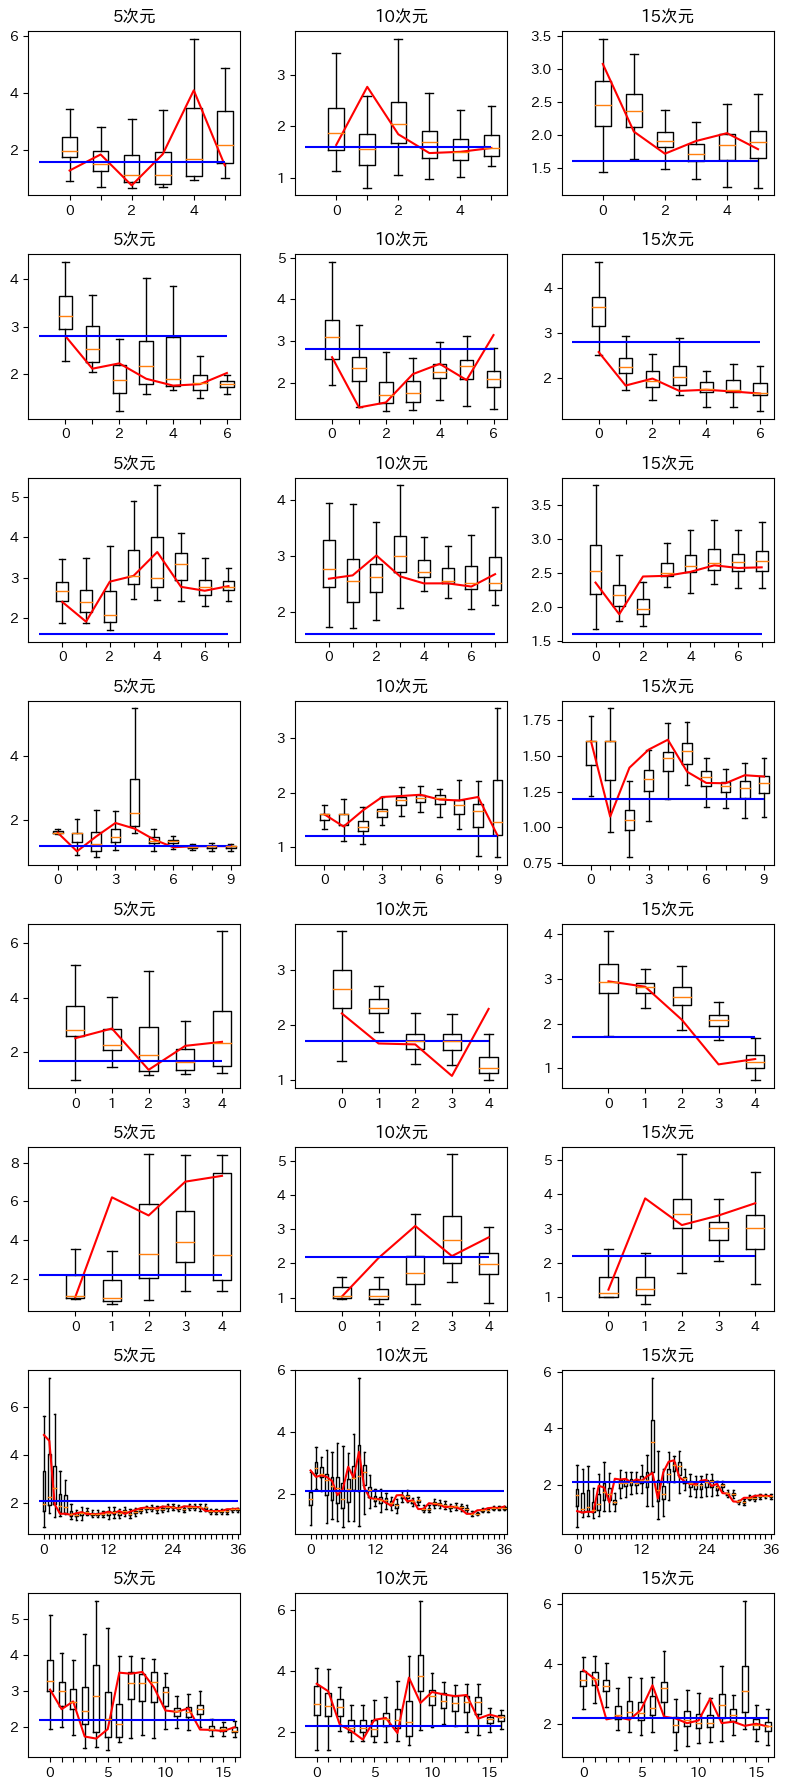

6 2 ['0', '', '2', '', '4', '']
10 3 ['0', '', '', '3', '', '', '6', '', '', '9']
6 2 ['0', '', '2', '', '4', '']
12 4 ['0', '', '', '', '4', '', '', '', '8', '', '', '']
7 2 ['0', '', '2', '', '4', '', '6']
14 4 ['0', '', '', '', '4', '', '', '', '8', '', '', '', '12', '']
7 2 ['0', '', '2', '', '4', '', '6']
7 2 ['0', '', '2', '', '4', '', '6']


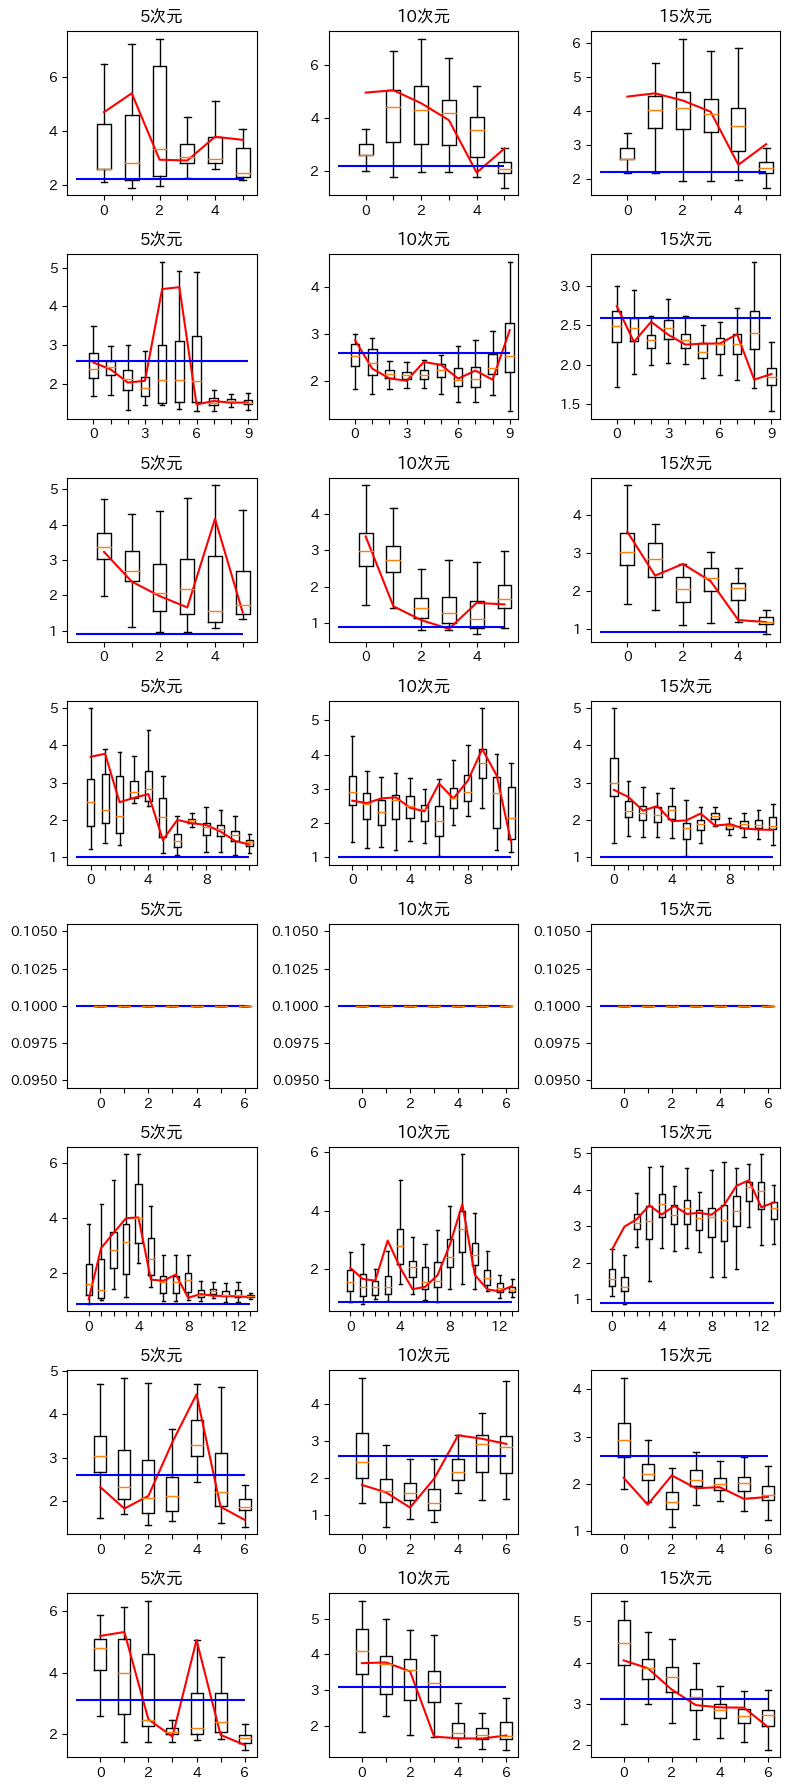

9 3 ['0', '', '', '3', '', '', '6', '', '']
7 2 ['0', '', '2', '', '4', '', '6']
5 1 ['0', '1', '2', '3', '4']
37 12 ['0', '', '', '', '', '', '', '', '', '', '', '', '12', '', '', '', '', '', '', '', '', '', '', '', '24', '', '', '', '', '', '', '', '', '', '', '', '36']
17 5 ['0', '', '', '', '', '5', '', '', '', '', '10', '', '', '', '', '15', '']


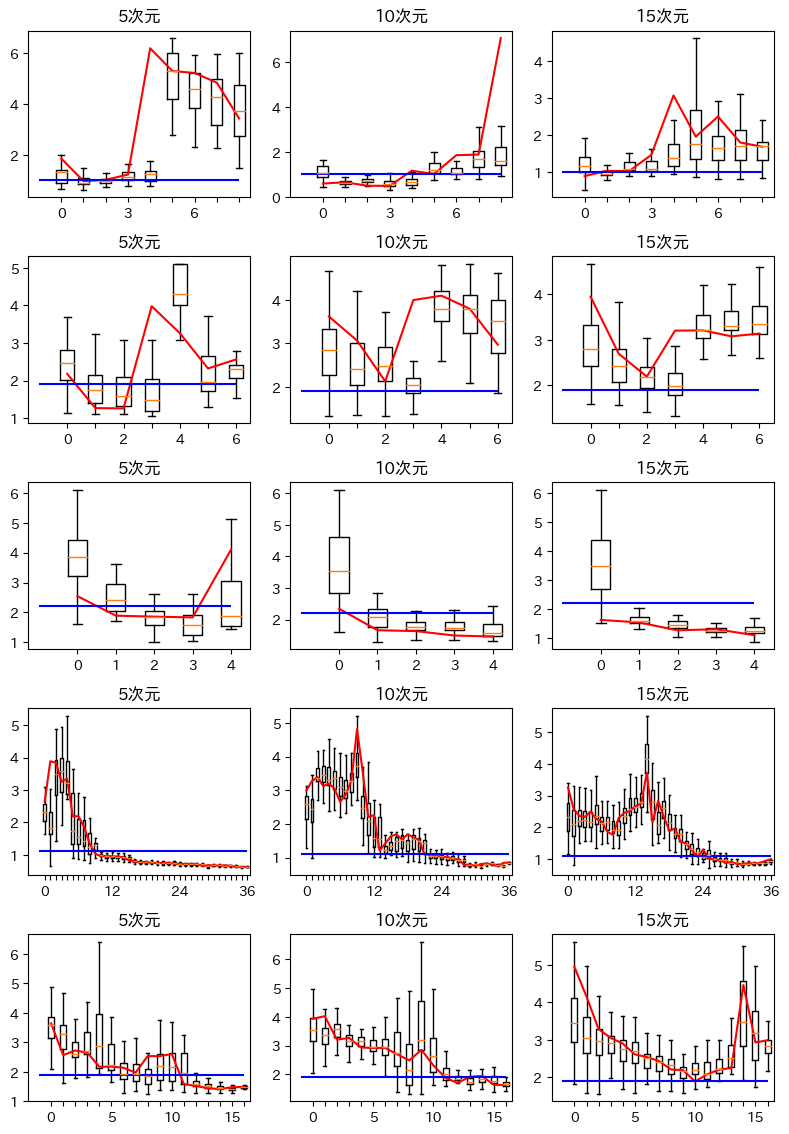

In [77]:
plt.rcParams["figure.figsize"] = (8, 18)
for sample_index, progress_result_sample in tqdm(enumerate(progress_result)):
    # 既存のプロットを初期化
    if sample_index % 8 == 0 and sample_index > 0:
        plt.tight_layout()
        plt.show()
        plt.clf()
    num_step = len(progress_result_sample["clicked_images"])
    sep = max(1, num_step//3)
    labels = [f"{i}" if i % sep == 0 else "" for i in range(num_step)]
    print(num_step, sep, labels)
    list(range(0, len(progress_result_sample["MAE"][5].keys()), max(1, len(progress_result_sample["MAE"][5].keys())%5)))
    for index, dim in enumerate(dims):
        plt.subplot(8, 3, sample_index%8*3+index+1)
        plt.boxplot([list(progress_result_sample["MAE"][dim][step].values()) for step in progress_result_sample["MAE"][5].keys()], labels=labels, showfliers=False)
        sns.lineplot(x=range(1, len(progress_result_sample["MAE_selected"][dim])+1), y=progress_result_sample["MAE_selected"][dim].values(), color="red")
        plt.hlines(df_result.loc[sample_index, "MAE"], 0, len(progress_result_sample["MAE"][dim]), color="blue")
        plt.title(f"{dim}次元")
    #plt.suptitle(f"サンプル{sample_index}", fontsize=32, y=0.2)
# サブプロットの間隔を調整
plt.tight_layout()
#plt.savefig(f"process_sample_new/process_0_10_3dim_{sample_index}.png")


In [ ]:
plt.rcParams["figure.figsize"] = (8, 4)
plt.bar(df_result.index, df_result.MAE)

In [ ]:
def map_3class(x):
    if x < 4:
        return 0
    elif x >6:
        return 2
    else:
        return 1

df_all_3class = df_all.applymap(map_3class)
df_drop_3class = df_drop.applymap(map_3class)

In [ ]:
df_drop_3class_ratio = pd.DataFrame()

for col in range(100):
    ratio = df_drop_3class.iloc[:, col].value_counts(normalize=True)
    ratio_list = [ratio[i] if i in ratio.keys() else 0 for i in range(3)]
    df_drop_3class_ratio[f"image{col}"] = ratio_list

In [ ]:
df_drop_3class.iloc[:, :15]

In [ ]:
for index, dim in enumerate((5, 15, 25)):
    plt.subplot(1, 3, index+1)
    sns.histplot(x=scat_nonzero[dim]["alpha"], y=scat_nonzero[dim]["count"])
    plt.xticks([-3, -2, -1])

In [ ]:
def update_ratio(values_to_match, df_3class, df_ratio):
    condition = None
    for index, val in values_to_match.items():
        if condition is None:
            condition = (df_3class[f"No.{index+1}の画像があなたの好みであるかを0から10で評価してください．"] == val)
        else:
            condition = condition & (df_3class[f"No.{index+1}の画像があなたの好みであるかを0から10で評価してください．"] == val)
    df_3class = df_3class[condition]
    columns_to_exclude = [f"No.{index+1}の画像があなたの好みであるかを0から10で評価してください．" for index in values_to_match.keys()]
    df_3class = df_3class[df_3class.columns.difference(columns_to_exclude)]

    df_ratio_new = pd.DataFrame()
    columns_set = set(df_3class.columns.tolist())
    for i in range(100):
        column_name = f"No.{i+1}の画像があなたの好みであるかを0から10で評価してください．"
        if column_name not in columns_set:
            continue
        ratio = df_3class[column_name].value_counts(normalize=True)
        ratio_list = [ratio[i] if i in ratio.keys() else 0 for i in range(3)]
        df_ratio_new[f"image{i}"] = ratio_list
    return df_3class, df_ratio_new

In [ ]:
for index, row in df_result.iterrows():
    if index < 5: continue
    df_3class = df_drop_3class
    df_ratio = df_drop_3class_ratio
    clicked_images = [int(x) for x in row["clicked_images"].split(",")]
    target_id = row["target_ID"]
    target_3class_row = df_all_3class.iloc[target_id]
    print(sorted(clicked_images[:3]))
    values_to_match = {}
    for i in sorted(clicked_images[:3]):
        values_to_match[i] = int(target_3class_row[f"No.{i+1}の画像があなたの好みであるかを0から10で評価してください．"])
    selected_columns = [f"No.{i+1}の画像があなたの好みであるかを0から10で評価してください．" for i in sorted(clicked_images[:3])]
    print(target_3class_row[selected_columns], values_to_match)
    df_3class, df_ratio = update_ratio(values_to_match, df_3class, df_ratio)
    if len(clicked_images) >= 6:
        next_3 = clicked_images[3:4]
        print(target_3class_row[[f"No.{i+1}の画像があなたの好みであるかを0から10で評価してください．" for i in sorted(clicked_images[3:6])]])
        selected_columns_3class = [f"No.{i+1}の画像があなたの好みであるかを0から10で評価してください．" for i in sorted(next_3)]
        print(target_3class_row[selected_columns_3class])
        selected_columns_ratio = [f"image{i}" for i in sorted(next_3)]
        values_to_match = {}
        for i in sorted(next_3):
            values_to_match[i] = int(target_3class_row[f"No.{i+1}の画像があなたの好みであるかを0から10で評価してください．"])
        df_3class, df_ratio = update_ratio(values_to_match, df_3class, df_ratio)
    break

df_3class

In [ ]:
df_all_var = df_all.var()

In [ ]:
df_all_var["No.77の画像があなたの好みであるかを0から10で評価してください．"]

In [ ]:
image_vars = []
max_len = 0
for index, row in df_result.iterrows():
    var_list = []
    clicked_count = row["clicked_count"]
    clicked_images = [int(x) for x in row["clicked_images"].split(",")]
    for image in clicked_images:
        var_list.append(df_all_var[f"No.{image+1}の画像があなたの好みであるかを0から10で評価してください．"])
    image_vars.append(var_list)
    max_len = max(max_len, clicked_count)

In [ ]:
plt.rcParams["figure.figsize"] = (8, 6)

# 折れ線グラフをプロット
for index, var_list in enumerate(image_vars):

    plt.plot(list(range(1, len(var_list)+1)), var_list)

    if index % 5 == 4:
        # グラフにタイトルと軸ラベルを追加
        plt.title('参加者のサンプルの分散')
        plt.xlabel('画像の番目')
        plt.ylabel('分散')

        # グラフを表示
        plt.show()

# グラフにタイトルと軸ラベルを追加
plt.title('参加者のサンプルの分散')
plt.xlabel('画像の番目')
plt.ylabel('分散')

# グラフを表示
plt.show()

In [ ]:
for index, row in df_result.iterrows():
    clicked_count = row["clicked_count"]
    clicked_images = [int(x) for x in row["clicked_images"].split(",")]
    sliced_clicked_images = [clicked_images[i:i+3] for i in range(0, len(clicked_images), 3)]
    for images in sliced_clicked_images:
        # 3個ずつ区切る場合の何らかの処理